In [1]:
import pandas as pd
import seaborn as sns
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit

# Root data path
DATA_PATH = '../data/'

#Data loading
df = pd.read_csv("resultFiles/featureExtractionV5_by_Jun/CD4.Ranksum.RFECV.act.csv", engine='c', index_col=0)
meta_data = pd.read_csv(DATA_PATH+'annotation_metadata/EPIC_HCvB_metadata_baseline_updated-share.csv')


In [2]:
## Utils and Library for notebook
from notebook_utils.OpenKbcMSToolkit import ExtractionToolkit as exttoolkit
import itertools
def _LoadDiseaseDuration(df, meta_data, returntype='long'):
    """
    df : Expression or activation score matrix
    meta_data : meta data which contains duration and sample ID
    output: long DD samples and short DD samples by list, or healthy samples and short DD samples by list
    """
    # checking multiple element for returntype
    if returntype.count(',')>1: raise ValueError('No more than 2 elements for returntype')

    if returntype.find(',')==-1: # if returnType is single(long and healthy)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category=='Healthy':
                healthy_samples = samples
            else:
                if category!='Unknown':# Excluding unknown samples
                    patient_samples.append(samples)

        patient_samples = list(itertools.chain(*patient_samples)) # flatten
        patient_samples = list(set(patient_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        healthy_samples = list(set(healthy_samples).intersection(df.columns.tolist())) # intersected with act score matrix
        patient_meta = meta_data.loc[meta_data['HCVB_ID'].isin(patient_samples)] # Make patient metadata

        longDD_samples, shortDD_samples = exttoolkit.get_sample_name_by_contValues(patient_meta, 'HCVB_ID', 'DiseaseDuration', 25)
        longDD_samples = list(set(longDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix
        shortDD_samples = list(set(shortDD_samples.values.tolist()).intersection(df.columns.tolist())) # intersected with act score matrix

    else: # if returnType is multiple(List)
        # Sample by disease category
        sample_list, sample_category = exttoolkit.get_sample_name_by_category(dataframe=meta_data, sampleColumn='HCVB_ID', dataColname='DiseaseCourse')
        category1 = returntype.split(',')[0]
        category2 = returntype.split(',')[1]
        
        # Sort by disease category and exclude uknown samples
        patient_samples = [] # patient samples
        healthy_samples = [] # healthy samples
        for samples, category in zip(sample_list, sample_category):
            if category==category1:
                category1_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix
            elif category==category2:
                category2_samples = list(set(samples).intersection(df.columns.tolist())) # intersected with act score matrix

    # return result
    if returntype=='long':
        return longDD_samples, shortDD_samples
    elif returntype=='healthy':
        return healthy_samples, shortDD_samples
    else:
        return category1_samples, category2_samples


In [3]:
df_cd4 = df.copy()
rr_samples, cis_samples = _LoadDiseaseDuration(df_cd4, meta_data, 'RR,CIS')
df_cd4 = df_cd4[rr_samples+cis_samples]
df_cd4 = df_cd4.subtract(df_cd4.median(axis=1), axis=0)

In [4]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = df_cd4.T.values
pca.fit(X)
x_updated = pca.transform(X)
x_updated.shape
pca_df = pd.DataFrame(data=x_updated, index=df_cd4.T.index, columns=['PCA1', 'PCA2'])
pca_df['disCourse'] = np.where(pca_df.index.isin(rr_samples),'rr', 'cis' )


<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

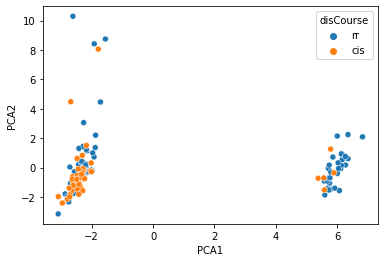

In [5]:
pca_df = pd.DataFrame(data=x_updated, index=df_cd4.T.index, columns=['PCA1', 'PCA2'])
pca_df['disCourse'] = np.where(pca_df.index.isin(rr_samples),'rr', 'cis' )
sns.scatterplot(x='PCA1', y='PCA2', hue='disCourse', data=pca_df)



In [6]:
pca_component_df = pd.DataFrame(data=pca.components_, columns=df_cd4.index, index=['PCA1c', 'PCA2c']).T # Components analysis
pca_component_df.sort_values(by=['PCA1c'], ascending=False)[:10]

,PCA1c,PCA2c
RUNNE_GENDER_EFFECT_UP,0.797640,-0.067941
PYEON_CANCER_HEAD_AND_NECK_VS_CERVICAL_DN,0.381754,-0.043354
GSE5099_DAY3_VS_DAY7_MCSF_TREATED_MACROPHAGE_DN,0.112523,0.022251
GSE3982_MEMORY_CD4_TCELL_VS_BCELL_UP,0.112184,-0.058952
GOMF_HISTONE_DEMETHYLASE_ACTIVITY_H3_K4_SPECIFIC,0.096819,-0.005817
GOMF_PROTEIN_DEMETHYLASE_ACTIVITY,0.094431,-0.009978
GOBP_HISTONE_H3_K4_DEMETHYLATION,0.090970,-0.001430
HP_ABNORMAL_SPERMATOGENESIS,0.090330,-0.005594
CARDOSO_RESPONSE_TO_GAMMA_RADIATION_AND_3AB,0.079927,0.006437
PGF_UP.V1_DN,0.069176,0.009733


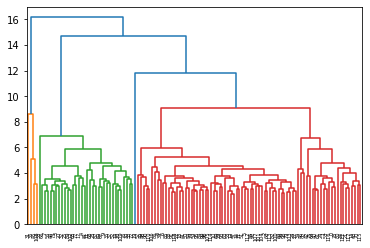

In [7]:
# Dendrogram generating
import scipy.cluster.hierarchy as hc
dendrogram = hc.dendrogram((hc.linkage(df_cd4.T, method ='complete')))

cluster_arr = []
for idx, cluster in zip(dendrogram['ivl'], dendrogram['leaves_color_list']):
    cluster_arr.append([df_cd4.T.index.tolist()[int(idx)], cluster])

/opt/miniconda3/envs/r-py-test/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


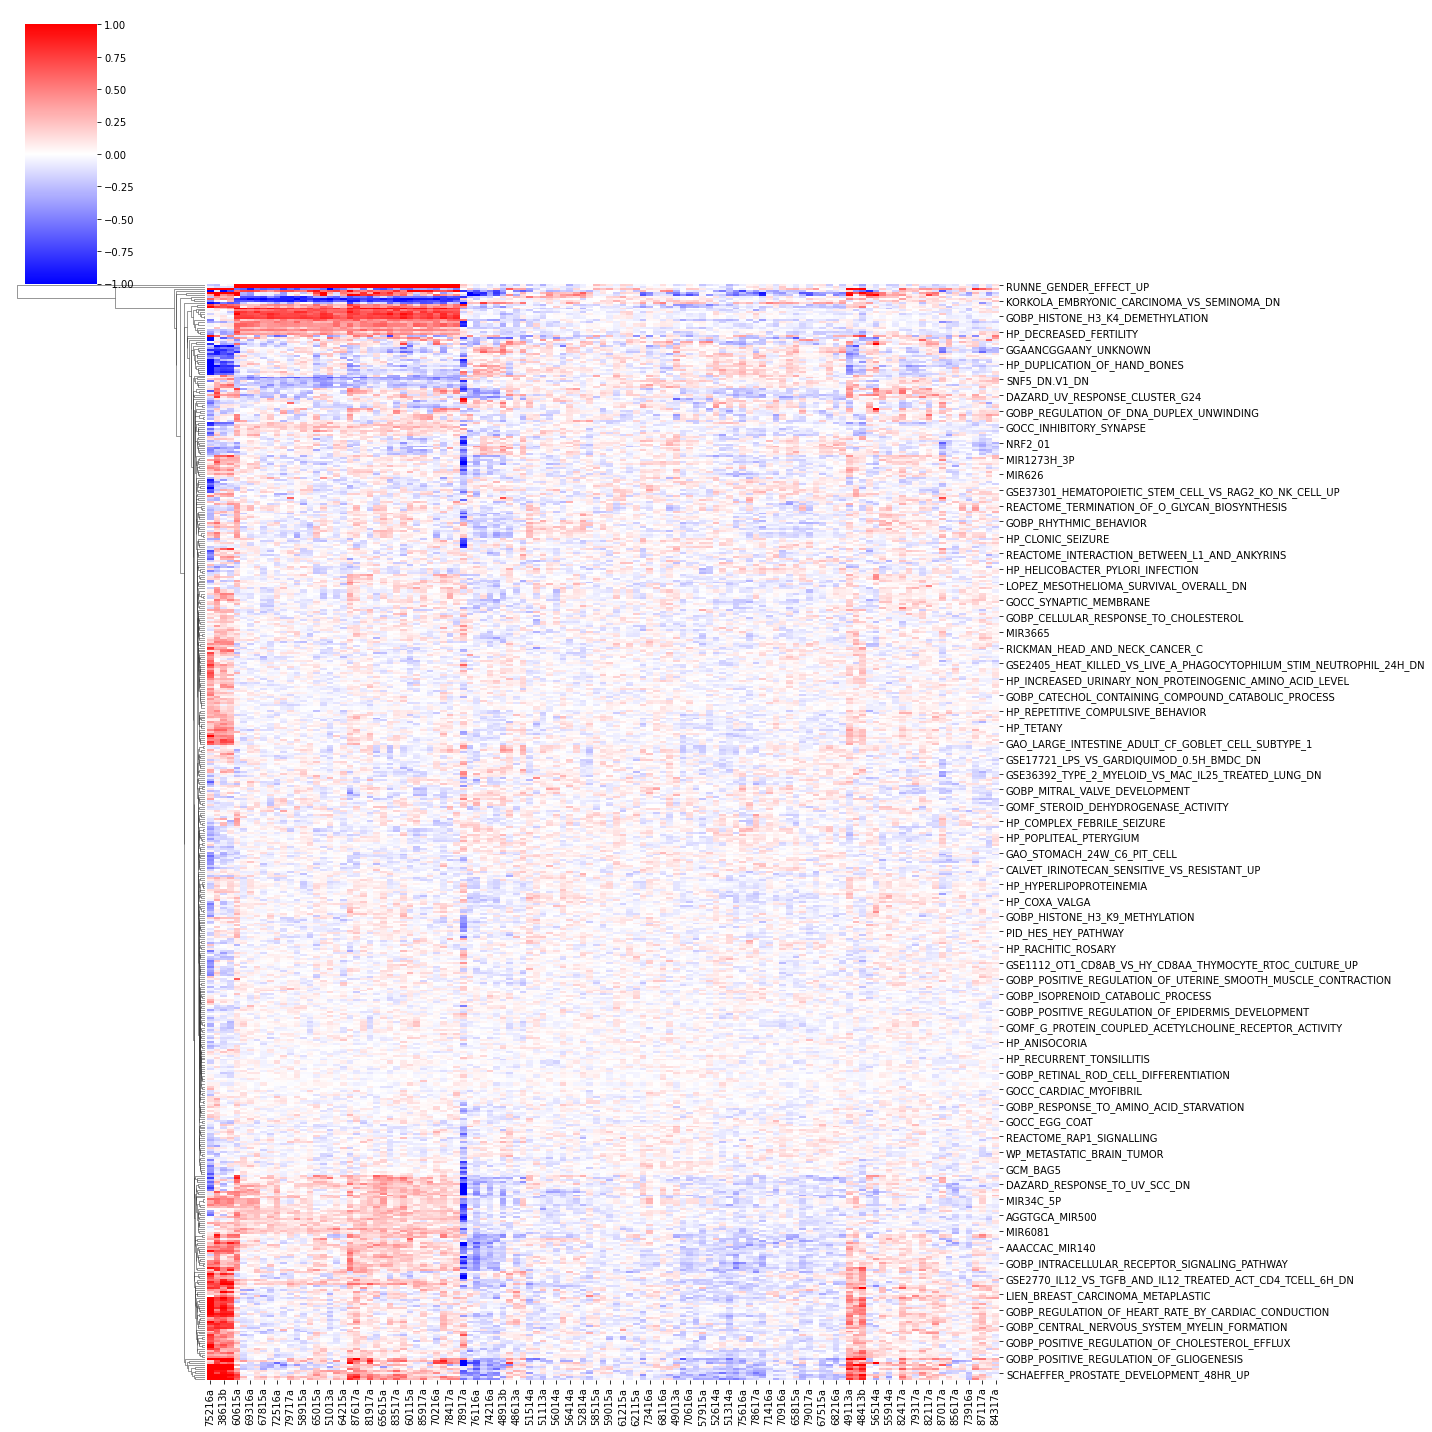

In [8]:
# Heatmap by dendrogram
c_sample_df = pd.DataFrame(data=cluster_arr, columns=['Sample', 'Cluster'])
sns.clustermap(df_cd4[c_sample_df['Sample']],col_cluster=False, figsize=(20,20), cmap='bwr', vmin=-1, vmax=1)

In [9]:
meta_copy1 = meta_data.copy()
meta_copy1 = meta_copy1.set_index('HCVB_ID')

c2_list = c_sample_df.loc[c_sample_df['Cluster']=='C2', 'Sample'].tolist() # Cluster 2
c3_list = c_sample_df.loc[c_sample_df['Cluster']=='C3', 'Sample'].tolist() # Cluster 3

meta_copy1 = meta_copy1.loc[c2_list+c3_list]

# Change all string value to int
for x in meta_copy1.columns.tolist():
    if meta_copy1[x].dtype=='object':

        value_list = meta_copy1[x].unique().tolist()
        vdict={}
        for i,item in enumerate(value_list):
            vdict[item] = i
        
        meta_copy1[x] = meta_copy1[x].map(vdict)
meta_copy1['Cluster'] = [1]*len(c2_list)+[2]*len(c3_list)


In [10]:
import statsmodels.api as sm
testset = meta_copy1.columns.tolist()
testset.pop(testset.index('Sex'))
test_df = meta_copy1[testset].dropna()
xl = test_df
yl = test_df[['Cluster']]
  
# building the model and fitting the data
xl = sm.add_constant(xl) # adding a constant

model = sm.OLS(yl, xl).fit()
predictions = model.predict(xl)
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                Cluster   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.124e+25
Date:                Sun, 17 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:03:49   Log-Likelihood:                 2515.3
No. Observations:                  89   AIC:                            -4963.
Df Residuals:                      55   BIC:                            -4878.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [14]:
meta_copy2 = meta_data.copy()
meta_copy2 = meta_copy2.set_index('HCVB_ID')
print(meta_copy2.loc[c2_list]['Sex'].value_counts())
print(meta_copy2.loc[c3_list]['Sex'].value_counts())

M    34
Name: Sex, dtype: int64
F    80
Name: Sex, dtype: int64
